In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed
# %env LD_LIBRARY_PATH=/home/ubuntu/miniconda3/envs/sab_env2/lib/python3.12/site-packages/nvidia/nvjitlink/lib/:$LD_LIBRARY_PATH
%env CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed


'MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed'

In [2]:
import json
import random
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn.functional as F
from monai.networks.nets import VNet
from skimage.measure import label
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

from funcs import *
from predict_funs import pred_attention, torch_percentile

%matplotlib inline

/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_5m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_11m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_21m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/ubuntu/Thesis_code/mo

In [1]:
!nvidia-smi --list-gpus

GPU 0: NVIDIA A100 80GB PCIe (UUID: GPU-c3316689-3235-53a1-8d30-24494d5868b9)
  MIG 3g.40gb     Device  0: (UUID: MIG-51be5228-6c6d-56ad-ae45-a73071efd76a)
  MIG 2g.20gb     Device  1: (UUID: MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed)
  MIG 1g.10gb     Device  2: (UUID: MIG-079b883d-bd08-5403-a958-cf1024f9dd0f)
  MIG 1g.10gb     Device  3: (UUID: MIG-564785c9-6926-50a7-8466-531d8603d411)
GPU 1: NVIDIA A100 80GB PCIe (UUID: GPU-e8dbd37f-2dc8-242c-e88a-814728409060)
  MIG 7g.80gb     Device  0: (UUID: MIG-3b133eb8-ed94-51f8-937f-cbc3e3f3ff2a)


In [4]:
import torch
torch.__version__

'2.4.0+cu121'

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA A100 80GB PCIe MIG 2g.20gb


In [3]:
device = torch.cuda.device(0)
device

In [3]:
SEED = 2003
NUM_TEST, NUM_VALID = 45, 45    # not directly used. for information
# IMGS_PATH = Path("/data/sab_data/images/resampled")
# MASKS_PATH = Path("/data/sab_data/masks/resampled")
IMGS_PATH = Path("/data/sab_data/images")
MASKS_PATH = Path("/data/sab_data/masks")
VNET_PATH = Path("/data/sab_data/checkpoints/atten.pth")

In [4]:
def sort_names(name):
    # Extract number
    match = re.search(r"(\d+)", name)
    # Extract type (t1, t2)
    type_match = re.search(r"_(t\d+)", name)
    type_str = type_match.group(1) if type_match else ""
    number = int(match.group(1)) if match else float("inf")
    return (number, type_str)


def find_matching_data(images_path: Path, masks_path: Path):
    """Get all the .nii.gz files in the folder if they have a corresponding .nrrd file"""
    files = []
    sorted_iter_dir = sorted(
        images_path.iterdir(), key=lambda x: sort_names(x.name), reverse=False
    )
    for file in sorted_iter_dir:
        if file.name[-7:] == ".nii.gz":
            mask_file = masks_path / (file.name[:-7] + ".nrrd")
            if mask_file.exists():
                files.append((file, mask_file))
    print(f"Found {len(files)} valid pairs of files")
    return files


def load_vnet(model_path: Path, device: str = "cuda"):
    vnet = VNet().to(device)
    vnet.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device(device),
        )
    )
    return vnet


def generate_attention_for_valid_slices(
    img_path: Path,
    mask_path: Path,
    vnet: torch.nn.Module,
    device: str = "cuda",
    lower_percentile: int = 1,
    upper_percentile: int = 99,
    progress_bar=True,
):
    """Given an image and mask path, validate the mask slices,
    save the slice number and returns paths"""
    attention_folder = "attention_maps_masked"
    result_dict = {}
    image_vol = sitk.ReadImage(img_path)
    image_tensor = torch.from_numpy(
        np.array(sitk.GetArrayFromImage(image_vol), dtype=np.float32)
    )
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    # Clip the data
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    # Normalize the data to [0, 1]
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)

    mask = sitk.ReadImage(mask_path)
    mask_tensor = torch.from_numpy(sitk.GetArrayFromImage(mask))
    smallest_dimension_index = np.argmin(mask_tensor.shape)
    if smallest_dimension_index != 0:
        image_tensor = torch.moveaxis(image_tensor, smallest_dimension_index, 0)
        mask_tensor = torch.moveaxis(mask_tensor, smallest_dimension_index, 0)
    image_tensor = mask_sacrum_volume(image_tensor, mask_tensor)
    n_slices = mask_tensor.shape[0]

    result_dict["image_path"] = str(img_path)
    result_dict["mask_path"] = str(mask_path)
    result_dict["original_size"] = image_tensor.shape[1:]
    attention_paths = {}
    with tqdm(
        total=n_slices,
        desc=f"Processing slices of {mask_path.name}",
        unit="slice",
        leave=False,
        disable=not progress_bar,
    ) as pbar:
        for slice_id in range(n_slices):
            # take a slice from the mask
            # mask_slice = np.take(mask_array, indices=slice_id, axis=0)
            # check if the mask contains any labels
            # if np.sum(mask_slice) < 1:
            #     # tqdm.write(f"No regions found in slice{i}")
            #     pbar.update(1)
            #     continue
            # else:
            atten_map = pred_attention(image_tensor, vnet, int(slice_id), device)
            attention_path = (
                img_path.parent
                / attention_folder
                / img_path.name.replace(".nii.gz", f"-{slice_id}.npy")
            )
            attention_path.parent.mkdir(parents=False, exist_ok=True)
            np.save(attention_path, np.array(atten_map))
            attention_paths[str(slice_id)] = str(attention_path)
            pbar.update(1)

    if len(attention_paths) < 1:
        print(img_path, mask_tensor.shape, image_tensor.shape)
        raise ValueError("Something wrong with mask array")
    result_dict["attention_path"] = attention_paths
    result_dict["slices"] = list(attention_paths.keys())
    return result_dict


def process_file_pairs(file_pairs: tuple[Path, Path], vnet: VNet, sub_bar=False):
    """Validate the data files and save the valid slices"""

    result_dict = {}
    with tqdm(
        total=len(file_pairs), desc="Validating data files", unit="image"
    ) as pbar:
        for img_path, mask_path in file_pairs:
            if img_path.name in result_dict:
                print(
                    f"Name of {img_path} is duplicate. It will overwrite the {result_dict[img_path.name]} data."
                )
            result_dict[img_path.name] = generate_attention_for_valid_slices(
                img_path,
                mask_path,
                vnet=vnet,
                device="cuda",
                lower_percentile=1,
                upper_percentile=99,
                progress_bar=sub_bar,
            )
            pbar.update(1)
    return result_dict


def allocate_samples(data_dict, n_t1=20, n_t2=21, n_space=4):
    all_keys = sorted(list(data_dict.keys()), key=sort_names)

    t1s = [x for x in all_keys if "t1" in x]
    t2s = [x for x in all_keys if "t2" in x and "SPACE" not in x]
    space = [x for x in all_keys if "SPACE" in x]

    train, test, valid = [], [], []
    random.seed(SEED)
    random.shuffle(t1s)
    random.shuffle(t2s)
    random.shuffle(space)
    test.extend(space[:n_space])
    valid.extend(space[n_space : 2 * n_space])
    train.extend(space[2 * n_space :])

    def find_match_id(group, rest):
        matches = []
        for x in group:
            id_part = x.split("_")[0]
            matches.extend([y for y in rest if id_part == y.split("_")[0]])
        return matches

    test.extend(find_match_id(test, t1s + t2s))
    valid.extend(find_match_id(valid, t1s + t2s))

    # Remove test and valid keys from t1s and t2s
    test_ids = {x.split("_")[0] for x in test}
    valid_ids = {x.split("_")[0] for x in valid}

    t1s = [
        x
        for x in t1s
        if x.split("_")[0] not in test_ids and x.split("_")[0] not in valid_ids
    ]
    t2s = [
        x
        for x in t2s
        if x.split("_")[0] not in test_ids and x.split("_")[0] not in valid_ids
    ]

    test_t1 = n_t1 - sum("t1" in x for x in test)
    valid_t1 = n_t1 - sum("t1" in x for x in valid)
    test_t2 = n_t2 - sum(("t2" in x and "SPACE" not in x) for x in test)
    valid_t2 = n_t2 - sum(("t2" in x and "SPACE" not in x) for x in valid)

    test.extend(t1s[:test_t1])
    valid.extend(t1s[test_t1 : test_t1 + valid_t1])
    train.extend(t1s[test_t1 + valid_t1 :])

    test.extend(t2s[:test_t2])
    valid.extend(t2s[test_t2 : test_t2 + valid_t2])
    train.extend(t2s[test_t2 + valid_t2 :])

    train_set = {key: val for key, val in data_dict.items() if key in train}
    test_set = {key: val for key, val in data_dict.items() if key in test}
    valid_set = {key: val for key, val in data_dict.items() if key in valid}
    # sort them
    train_set = {
        key: train_set[key] for key in sorted(train_set.keys(), key=sort_names)
    }
    test_set = {key: test_set[key] for key in sorted(test_set.keys(), key=sort_names)}
    valid_set = {
        key: valid_set[key] for key in sorted(valid_set.keys(), key=sort_names)
    }
    return train_set, test_set, valid_set


def make_data_files_with_attention(
    images_path: Path,
    masks_path: Path,
    model_path: Path,
    device: str = "cuda:0",
    sub_bar=False,
):
    """Make the data files for the images and masks"""
    file_pairs = find_matching_data(images_path, masks_path)
    vnet = load_vnet(model_path, device)
    result_dict = process_file_pairs(file_pairs, vnet=vnet, sub_bar=sub_bar)
    # Separate train test files
    train, test, valid = allocate_samples(result_dict)

    return train, test, valid

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"
train_set, test_set, valid_set = make_data_files_with_attention(
    images_path=IMGS_PATH,
    masks_path=MASKS_PATH,
    model_path=VNET_PATH,
    device=device,
    sub_bar=False,
)
with open("Train_data_files_resampled_masking.json", "w") as f:
    json.dump(
        train_set,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )
with open("Test_data_files_resampled_masking.json", "w") as f:
    json.dump(
        test_set,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )
with open("Validation_data_files_resampled_masking.json", "w") as f:
    json.dump(
        valid_set,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )

Found 447 valid pairs of files


/tmp/ipykernel_171461/1207347915.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


Validating data files:   0%|          | 0/447 [00:00<?, ?image/s]

In [23]:
checkpoint_directory = Path('./checkpoints') 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model_path = checkpoint_directory / "atten.pth"
test_dict = json.load(open("leaky_data_files/Test_data_files.json", "r"))
train_dict = json.load(open("leaky_data_files/Train_data_files.json", "r"))

cuda


In [28]:
test_keys, train_keys = list(test_dict.keys()), list(train_dict.keys())
print("All volumes:", len(test_keys) + len(train_keys))
all_keys = test_keys + train_keys
t1s = [x for x in all_keys if "t1" in x]
print("T1 volumes:", len(t1s))
t2s = [x for x in all_keys if "t2" in x and "SPACE" not in x]
space = [x for x in all_keys if "SPACE" in x]
print("T2s and SPACE T2s:", len(t2s), len(space))
# test, valid, train = [], [], []
# random.seed(SEED)
# random.shuffle(t1s),
# random.shuffle(t2s)
# random.shuffle(space)
# test.extend(space[:4])
# valid.extend(space[4:8])
# train.extend(space[8:])


# def find_match_id(group, rest):
#     matches = []
#     for x in group:
#         id_part = x.split("_")[0]
#         matches.extend([y for y in rest if id_part == y.split("_")[0]])
#     return matches


# test.extend(find_match_id(test, t1s + t2s))
# valid.extend(find_match_id(valid, t1s + t2s))

# # Remove test and valid keys from t1s and t2s
# test_ids = {x.split("_")[0] for x in test}
# valid_ids = {x.split("_")[0] for x in valid}

# t1s = [
#     x
#     for x in t1s
#     if x.split("_")[0] not in test_ids and x.split("_")[0] not in valid_ids
# ]
# t2s = [
#     x
#     for x in t2s
#     if x.split("_")[0] not in test_ids and x.split("_")[0] not in valid_ids
# ]


# Allocate the rest to train, test, and valid sets
def allocate_samples(data_dict):
    n_t1 = 20
    n_t2 = 21
    n_space = 4
    all_keys = sorted(list(data_dict.keys()), key=sort_names)

    t1s = [x for x in all_keys if "t1" in x]
    t2s = [x for x in all_keys if "t2" in x and "SPACE" not in x]
    space = [x for x in all_keys if "SPACE" in x]

    train, test, valid = [], [], []
    random.seed(SEED)
    random.shuffle(t1s)
    random.shuffle(t2s)
    random.shuffle(space)
    test.extend(space[:n_space])
    valid.extend(space[n_space : 2 * n_space])
    train.extend(space[2 * n_space :])

    def find_match_id(group, rest):
        matches = []
        for x in group:
            id_part = x.split("_")[0]
            matches.extend([y for y in rest if id_part == y.split("_")[0]])
        return matches

    test.extend(find_match_id(test, t1s + t2s))
    valid.extend(find_match_id(valid, t1s + t2s))

    # Remove test and valid keys from t1s and t2s
    test_ids = {x.split("_")[0] for x in test}
    valid_ids = {x.split("_")[0] for x in valid}

    t1s = [
        x
        for x in t1s
        if x.split("_")[0] not in test_ids and x.split("_")[0] not in valid_ids
    ]
    t2s = [
        x
        for x in t2s
        if x.split("_")[0] not in test_ids and x.split("_")[0] not in valid_ids
    ]

    test_t1 = n_t1 - sum("t1" in x for x in test)
    valid_t1 = n_t1 - sum("t1" in x for x in valid)
    test_t2 = n_t2 - sum(("t2" in x and "SPACE" not in x) for x in test)
    valid_t2 = n_t2 - sum(("t2" in x and "SPACE" not in x) for x in valid)

    test.extend(t1s[:test_t1])
    valid.extend(t1s[test_t1 : test_t1 + valid_t1])
    train.extend(t1s[test_t1 + valid_t1 :])

    test.extend(t2s[:test_t2])
    valid.extend(t2s[test_t2 : test_t2 + valid_t2])
    train.extend(t2s[test_t2 + valid_t2 :])

    train_set = {key: val for key, val in data_dict.items() if key in train}
    test_set = {key: val for key, val in data_dict.items() if key in test}
    valid_set = {key: val for key, val in data_dict.items() if key in valid}
    # sort them
    train_set = {
        key: train_set[key] for key in sorted(train_set.keys(), key=sort_names)
    }
    test_set = {key: test_set[key] for key in sorted(test_set.keys(), key=sort_names)}
    valid_set = {
        key: valid_set[key] for key in sorted(valid_set.keys(), key=sort_names)
    }
    return train_set, test_set, valid_set


train, test, valid = allocate_samples(train_dict | test_dict)

print("Test Set:", len(test), test.keys())
print("Validation Set:", len(valid), valid.keys())
print("Train Set:", len(train), train.keys())

All volumes: 447
T1 volumes: 196
T2s and SPACE T2s: 210 41
Test Set: 45 dict_keys(['7_t1.nii.gz', '7_t2.nii.gz', '7_t2_SPACE.nii.gz', '24_t2.nii.gz', '28_t2.nii.gz', '39_t2.nii.gz', '45_t2.nii.gz', '50_t1.nii.gz', '50_t2_SPACE.nii.gz', '50_t2.nii.gz', '56_t1.nii.gz', '57_t1.nii.gz', '62_t2.nii.gz', '67_t2.nii.gz', '69_t1.nii.gz', '69_t2_SPACE.nii.gz', '69_t2.nii.gz', '71_t2.nii.gz', '81_t2.nii.gz', '83_t1.nii.gz', '109_t1.nii.gz', '117_t1.nii.gz', '118_t1.nii.gz', '131_t1.nii.gz', '140_t1.nii.gz', '140_t2.nii.gz', '145_t1.nii.gz', '146_t1.nii.gz', '166_t1.nii.gz', '186_t2.nii.gz', '191_t1.nii.gz', '192_t1.nii.gz', '193_t2.nii.gz', '204_t1.nii.gz', '204_t2.nii.gz', '208_t2.nii.gz', '222_t2.nii.gz', '224_t1.nii.gz', '226_t1.nii.gz', '226_t2.nii.gz', '236_t2.nii.gz', '241_t1.nii.gz', '241_t2_SPACE.nii.gz', '241_t2.nii.gz', '257_t2.nii.gz'])
Validation Set: 45 dict_keys(['4_t2.nii.gz', '5_t1.nii.gz', '8_t2.nii.gz', '12_t1.nii.gz', '13_t2.nii.gz', '16_t1.nii.gz', '22_t1.nii.gz', '22_t2_SPAC

In [47]:
def resize_sitk(image, new_size, interpolator=sitk.sitkLinear):
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()

    new_spacing = [
        (original_size[i] * original_spacing[i]) / new_size[i] for i in range(3)
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetInterpolator(interpolator)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    resample.SetDefaultPixelValue(image.GetPixelIDValue())

    return resample.Execute(image)


def resize_torch_volume(
    tensor, new_size: tuple[int, int, int] = (64, 64, 64), mode="trilinear"
):
    """
    Resize a 3D volume using PyTorch.

    Args:
    - volume (torch.Tensor): The input volume tensor of shape (D, H, W) or (B, D, H, W).
    - new_size (list or tuple): The desired output size as (D, H, W).
    - mode (str): The interpolation mode. Default is 'trilinear'.

    Returns:
    - torch.Tensor: The resized volume tensor of shape (D, H, W) or (B, D, H, W).
    """
    is_batched = True
    if len(tensor.shape) == 3:
        is_batched = False
        tensor = tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimension
    elif len(tensor.shape) == 4:
        tensor = tensor.unsqueeze(1)  # Add channel dimension
    # Resize the volume
    resized_tensor = F.interpolate(
        tensor, size=new_size, mode=mode, align_corners=False
    ).squeeze(1)
    # Remove the batch dimension if it was added
    if not is_batched:
        resized_tensor = resized_tensor.squeeze(0)
    return resized_tensor


image_vol = torch.from_numpy(
    np.array(sitk.GetArrayFromImage(sitk.ReadImage(img_path)), dtype=np.float32)
)
print(image_vol.shape)
image_vol = resize_torch_volume(image_vol, new_size=(64, 64, 64))
print(image_vol.shape)

torch.Size([1, 512, 120, 640])
torch.Size([1, 64, 64, 64])


In [50]:
np.squeeze(np.zeros((1,1,3,3,3))).shape

(3, 3, 3)

In [5]:
img_path = IMGS_PATH / "185_t2_SPACE.nii.gz"
mask_path = MASKS_PATH / "185_t2_SPACE.nrrd"
image_vol = sitk.ReadImage(img_path)
image_tensor = torch.from_numpy(np.array(sitk.GetArrayFromImage(image_vol), dtype=np.uint8))
lower_bound = torch_percentile(image_tensor, 1)
upper_bound = torch_percentile(image_tensor, 99)
# Clip the data
image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
# Normalize the data to [0, 1]
image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)

mask = sitk.ReadImage(mask_path)
mask_tensor = sitk.GetArrayFromImage(mask)
smallest_dimension_index = np.argmin(mask_tensor.shape)
print(image_tensor.shape, mask_tensor.shape, smallest_dimension_index)
if smallest_dimension_index != 0:
    image_tensor = torch.moveaxis(image_tensor, smallest_dimension_index, 0)
    mask_tensor = np.moveaxis(mask_tensor, smallest_dimension_index, 0)
    if image_tensor.shape[1] < image_tensor.shape[2]:
        image_tensor = torch.swapaxes(image_tensor, 1, 2)
        mask_tensor = np.swapaxes(mask_tensor, 1, 2)
print(image_tensor.shape)
image_tensor = resize_torch_volume(image_tensor.to(torch.float32), new_size=(64,64,64)).to(torch.uint8)
print(mask_tensor.shape, image_tensor.shape)
plt.imshow(mask_tensor[65], cmap="gray")
plt.show()

torch.Size([512, 120, 640]) (512, 120, 640) 1
torch.Size([120, 640, 512])


NameError: name 'resize_torch_volume' is not defined

In [10]:
img_path = IMGS_PATH / "184_t2.nii.gz"
mask_path = MASKS_PATH / "190_t2.nrrd"
image_vol = sitk.ReadImage(img_path)
image_vol.GetSpacing()


(0.6034292578697205, 0.3592572808265686, 4.395938396453857)

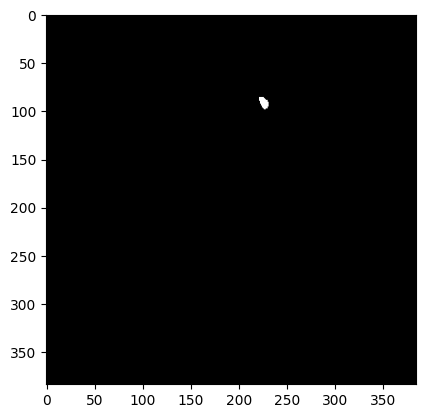

In [38]:
msk = np.load(test_set["8_t1.nii.gz"]["0"]["mask_path"])
plt.imshow(msk, cmap="gray")
plt.show()

In [6]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = plt.get_cmap('Accent')

# Convert the colormap to an array of colors
colors = cmap(np.linspace(0, 1, cmap.N))

# Change the color for value 0 (first entry in the array)
colors[0] = np.array([0, 0, 0, 1])  # Example: set to white

# Create a new colormap with the modified colors
new_cmap = ListedColormap(colors)

name:9_t2,	Slide:9
sitk size:(603, 610, 19), array size: (19, 610, 603)
sitk size:(19, 384, 610), array size: (610, 384, 19)


/tmp/ipykernel_81353/2374262982.py:21: RuntimeWarning: divide by zero encountered in log10
  sliced_mask_nrrd = np.log10(sliced_mask_nrrd)


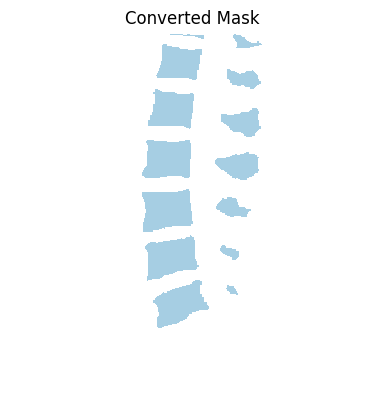

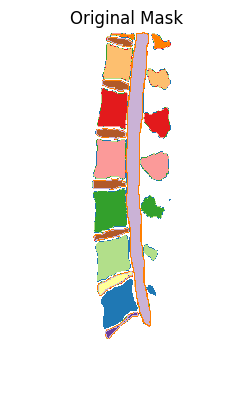

In [8]:
file_name = "9_t2"
nrrd_path = Path("/data/sab_data/masks/")
mha_path = Path("/data/sab_data/masks/original")
slide_to_check = 9
print(f"name:{file_name},\tSlide:{slide_to_check}")

sample_mask_nrrd = sitk.ReadImage(nrrd_path / (file_name + ".nrrd"))
sample_mask_nrrd = match_voxels(sample_mask_nrrd, sitk.sitkNearestNeighbor)
print(
    f"sitk size:{sample_mask_nrrd.GetSize()}, array size: {sitk.GetArrayFromImage(sample_mask_nrrd).shape}"
)
smallest_dimension_index = np.argmin(sitk.GetArrayFromImage(sample_mask_nrrd).shape)
sliced_mask_nrrd = np.flipud(
    np.take(
        sitk.GetArrayFromImage(sample_mask_nrrd),
        indices=slide_to_check,
        axis=smallest_dimension_index,
    )
)
# sliced_mask_nrrd[sliced_mask_nrrd == 0] = +50
sliced_mask_nrrd = np.log10(sliced_mask_nrrd)

sample_mask_mha = sitk.ReadImage(mha_path / (file_name + ".mha"))
# sample_mask_mha = match_voxels(sample_mask_mha, sitk.sitkNearestNeighbor)
print(
    f"sitk size:{sample_mask_mha.GetSize()}, array size: {sitk.GetArrayFromImage(sample_mask_mha).shape}"
)
smallest_dimension_index = np.argmin(sitk.GetArrayFromImage(sample_mask_mha).shape)
sliced_mask_mha = np.flipud(
    np.take(
        sitk.GetArrayFromImage(sample_mask_mha),
        indices=slide_to_check,
        axis=smallest_dimension_index,
    )
)
unique_labels = np.unique(sliced_mask_mha)
pastel1 = plt.get_cmap("Paired")
color_list = ['white'] +  [pastel1(i) for i in range(1, len(unique_labels))]
cmap = mcolors.ListedColormap(color_list)
norm = mcolors.BoundaryNorm(
    boundaries=np.append(unique_labels - 0.5, unique_labels[-1] + 0.5),
    ncolors=len(unique_labels),
)
# sliced_mask_mha = np.log10(sliced_mask_mha)
# sliced_mask_mha[sliced_mask_mha == 0] = np.log10(500)
plt.imshow(sliced_mask_nrrd, cmap="Paired")
plt.title("Converted Mask")
plt.axis("off")
plt.show()
plt.imshow(sliced_mask_mha, cmap=cmap, norm=norm)
plt.axis("off")
plt.title("Original Mask")
plt.show()

In [9]:
sitk.ReadImage("/data/sab_data/images/182_t1.nii.gz").GetSpacing()

(0.875, 0.875, 4.799999713897705)

In [4]:
with open("Test_data_files_resampled.json", "r") as f:
    test_set = json.load(f)
with open("Train_data_files_resampled.json", "r") as f:
    train_set = json.load(f)


def extract_original_sizes(data_file):
    result = {}
    for key, value in data_file.items():
        img = sitk.ReadImage(value["image_path"])
        spacing = img.GetSpacing()
        original_size = img.GetSize()
        result[key] = {
            "pixels": original_size,
            "spacing": spacing,
        }
    return result
test_size_space = extract_original_sizes(test_set)
train_size_space = extract_original_sizes(train_set)
print(len(test_size_space), len(train_size_space))

90 357


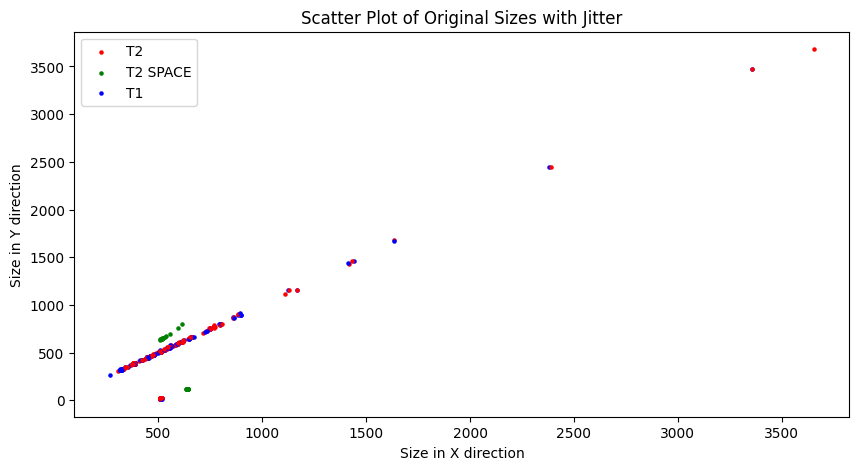

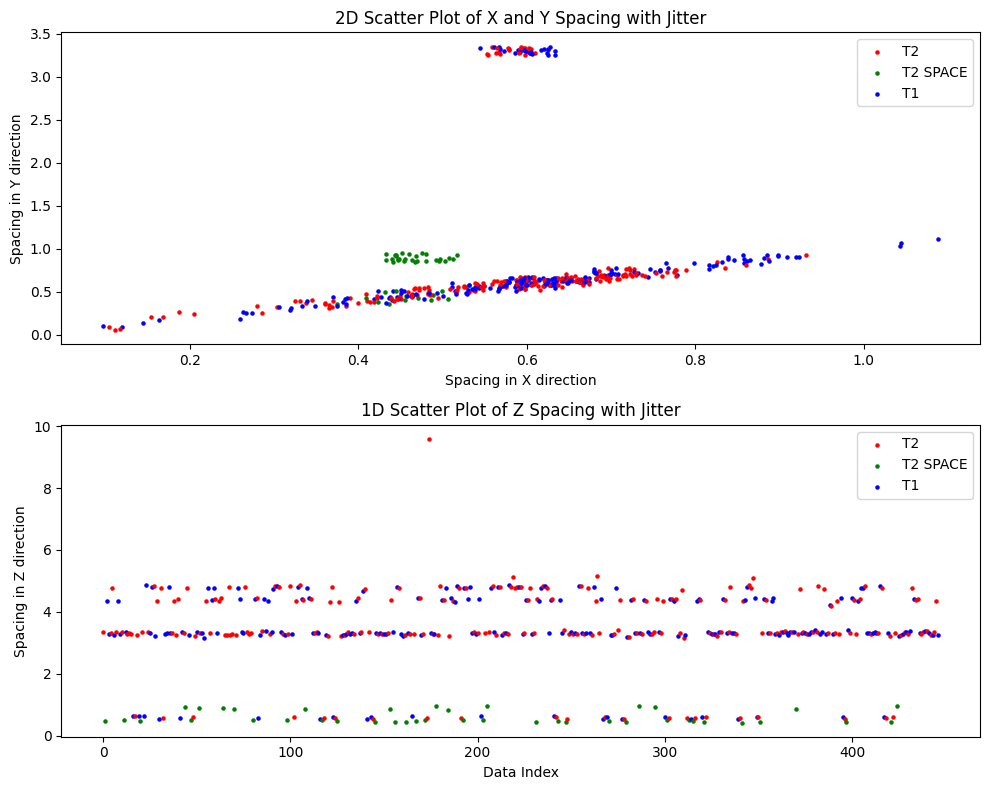

In [5]:
def plot_size_with_jitter(data_dict, key, jitter_v=0.5):
    sizes = [x[key] for x in data_dict.values()]
    x_sizes = [size[0] for size in sizes]
    y_sizes = [size[1] for size in sizes]
    
    # Add jitter to the sizes
    x_sizes_jittered = x_sizes + np.random.uniform(-jitter_v, jitter_v, size=len(x_sizes))
    y_sizes_jittered = y_sizes + np.random.uniform(-jitter_v, jitter_v, size=len(y_sizes))
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    
    # Plot sizes with colors based on key
    for i, key in enumerate(data_dict.keys()):
        color = 'blue' if 't1' in key else 'red' if ('t2' in key and "SPACE" not in key) else 'green'
        label = 'T1' if 't1' in key else 'T2' if ('t2' in key and "SPACE" not in key) else 'T2 SPACE'
        ax.scatter(x_sizes_jittered[i], y_sizes_jittered[i], s=5, color=color, label=label)
    
    ax.set_xlabel('Size in X direction')
    ax.set_ylabel('Size in Y direction')
    ax.set_title('Scatter Plot of Original Sizes with Jitter')
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.show()

def plot_spacing_with_jitter(data_dict, key, jitter_v=0.05):
    spacings = [x[key] for x in data_dict.values()]
    x_spacing = [spacing[0] for spacing in spacings]
    y_spacing = [spacing[1] for spacing in spacings]
    z_spacing = [spacing[2] for spacing in spacings]

    # Add jitter to the spacings
    x_spacing_jittered = x_spacing + np.random.uniform(-jitter_v, jitter_v, size=len(x_spacing))
    y_spacing_jittered = y_spacing + np.random.uniform(-jitter_v, jitter_v, size=len(y_spacing))
    z_spacing_jittered = z_spacing + np.random.uniform(-jitter_v, jitter_v, size=len(z_spacing))

    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot x and y spacing in 2D with colors based on key
    for i, key in enumerate(data_dict.keys()):
        color = 'blue' if 't1' in key else 'red' if ('t2' in key and "SPACE" not in key) else 'green'
        label = 'T1' if 't1' in key else 'T2' if ('t2' in key and "SPACE" not in key) else 'T2 SPACE'
        ax1.scatter(x_spacing_jittered[i], y_spacing_jittered[i], s=5, color=color, label=label)
    
    ax1.set_xlabel('Spacing in X direction')
    ax1.set_ylabel('Spacing in Y direction')
    ax1.set_title('2D Scatter Plot of X and Y Spacing with Jitter')

    # Plot z spacing in 1D with colors based on key
    for i, key in enumerate(data_dict.keys()):
        color = 'blue' if 't1' in key else 'red' if ('t2' in key and "SPACE" not in key) else 'green'
        label = 'T1' if 't1' in key else 'T2' if ('t2' in key and "SPACE" not in key) else 'T2 SPACE'
        ax2.scatter(i, z_spacing_jittered[i], s=5, color=color, label=label)
    
    ax2.set_xlabel('Data Index')
    ax2.set_ylabel('Spacing in Z direction')
    ax2.set_title('1D Scatter Plot of Z Spacing with Jitter')

    # Add legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys())

    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

merged = test_size_space | train_size_space
plot_size_with_jitter(merged, "pixels", jitter_v=5)
plot_spacing_with_jitter(merged, "spacing", jitter_v=0.05)

In [6]:
""" resample images to isotropic voxel sizes """
test_data_file = "Test_data_files.json"
train_data_file = "Train_data_files.json"
with open(test_data_file, "r") as f:
    test_data_dict = json.load(f) 
with open(train_data_file, "r") as f:
    train_data_dict = json.load(f) 



In [32]:
import pandas as pd
def correct_spacing_order(tup):
    """Corrects the tuple if Y and Z values are switched."""
    x, y, z = tup
    # Assuming Z should be the largest value
    if y > z:
        y, z = z, y
    return (x, y, z)
df = pd.DataFrame.from_dict(test_size_space).T
# df[['X_spc', 'Y_spc', 'Z_spc']] = pd.DataFrame(df["spacing"].tolist(), index=df.index)
df[['X_pxl', 'Y_pxl', 'Z_pxl']] = pd.DataFrame(df["pixels"].tolist(), index=df.index)
df[['X_spc', 'Y_spc', 'Z_spc']] = df["spacing"].apply(correct_spacing_order).to_list()
df.drop(["pixels", "spacing"], axis=1, inplace=True)
df.mean()

X_pxl    487.277778
Y_pxl    495.566667
Z_pxl    104.200000
X_spc      0.611588
Y_spc      0.595525
Z_spc      3.442204
dtype: float64

In [4]:
def match_voxels(orig_image, interpolator=sitk.sitkLinear):
    # orig_image = sitk.ReadImage(file_path)

    # Get the original spacing
    original_spacing = np.array(orig_image.GetSpacing())
    sorted_arg = np.argsort(original_spacing)
    min_spacing = original_spacing.min()
    new_spacing = original_spacing.copy()
    new_spacing[[sorted_arg[0], sorted_arg[1]]] = min_spacing, min_spacing

    # Compute the new size based on the new spacing
    original_size = orig_image.GetSize()
    new_size = [
        int(round(osz * ospc / nspc))
        for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)
    ]

    # Resample the image
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(orig_image.GetDirection())
    resampler.SetOutputOrigin(orig_image.GetOrigin())
    resampler.SetInterpolator(interpolator)

    resampled_img = resampler.Execute(orig_image)
    return resampled_img


# names_list = list(train_data_dict.keys())
# img = sitk.ReadImage(train_data_dict[names_list[0]]["image_path"])
# resampled = match_voxels(img)

In [23]:
merged_data_dict = test_data_dict | train_data_dict
names_list = list(merged_data_dict.keys())
for img in names_list:
    orig = sitk.ReadImage(merged_data_dict[img]["image_path"])
    # linear for image slices
    resampled = match_voxels(orig, sitk.sitkLinear)
    img_path = Path(merged_data_dict[img]["image_path"])
    save_path = img_path.parent / ("resampled/" + img_path.name)
    sitk.WriteImage(resampled, save_path)


In [27]:
merged_data_dict = test_data_dict | train_data_dict
names_list = list(merged_data_dict.keys())
for img in names_list:
    orig = sitk.ReadImage(merged_data_dict[img]["mask_path"])
    # nearest neighbour for masks
    resampled = match_voxels(orig, sitk.sitkNearestNeighbor)
    img_path = Path(merged_data_dict[img]["mask_path"])
    save_path = img_path.parent / ("resampled/" + img_path.name)
    sitk.WriteImage(resampled, save_path)
